In [68]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import animation
from IPython.display import HTML
import seaborn as sns

from tqdm import tqdm
from scipy.spatial.distance import pdist, cdist, squareform
from scipy.stats import pearsonr, spearmanr, entropy, rankdata
from sklearn.manifold import MDS
from scipy.ndimage import gaussian_filter1d

RAND = 0
RESP = (50,220)
BASE = (-50,0)
ONSET = 50
RESP = slice(ONSET + RESP[0], ONSET + RESP[1])
BASE = slice(ONSET + BASE[0], ONSET + BASE[1])

In [89]:
DATA_DIR = '../../datasets/NNN/'
dat = pd.read_pickle(os.path.join(DATA_DIR, ('object_roi_data.pkl')))
print(f'Unique face ROIs: {list(dat['roi'].unique())}')

with open('../../datasets/NNN/object_mins.pkl', 'rb') as f:
    mins = pickle.load(f)

Unique face ROIs: ['MO2_21_O', 'Unknown_22_O', 'Unknown_11_O', 'MO1s1_4_O', 'Unknown_4_O', 'LPP4_1_O', 'LPP1_2_O', 'Unknown_15_O', 'CLC3_13_O', 'Unknown_14_O', 'AO2_24_O', 'PITP4_10_O', 'Unknown_6_O', 'MO1s2_5_O', 'Unknown_16_O', 'Unknown_26_O', 'AO5_25_O']


In [7]:
def geo_rdm(dat, roi, mode='top', step=5, k_max=200, metric='correlation', random_state=RAND):
    rng = np.random.default_rng(random_state)
    sig = dat[dat['p_value'] < 0.05]
    df = sig[sig['roi'] == roi]
    if len(df) == 0:
        raise ValueError(f"No data for ROI {ROI}")
    X = np.stack(df['img_psth'].to_numpy())          # (units, time, images)

    scores = np.nanmean(X[:, RESP, :], axis=(0,1)) - np.nanmean(X[:, BASE, :], axis=(0,1))
    order = np.argsort(scores)[::-1] if mode == 'top' else rng.permutation(scores.size)

    # ================= choose the image-set bins to calculate RDMs ========
    sizes = [k for k in range(step, min(k_max, X.shape[2]) + 1, step)]
    # =================== ramping step size ================================ 
    # sizes = [k for k in range(1, 2*step)] + [k for k in range(2*step, min(k_max, X.shape[2])+1, step)]
    
    rdvs = []
    for k in tqdm(sizes):
        idx = order[:k]
        Ximg = X[:, 100:400, idx] # (units, time, images)
        Xrdv = np.array([pdist(Ximg[:, t, :].T, metric='correlation') for t in range(Ximg.shape[1])])
        # spearman instead of correlation
        Xrdv = np.apply_along_axis(rankdata, 1, Xrdv)
        R = squareform(pdist(Xrdv, metric=metric))   # (time, time)
        rdvs.append(R)
    return sizes, rdvs

def static_rdm(dat, roi, mode='top', scale=30, tstart=100, tend=400, metric='correlation', random_state=RAND):
    rng = np.random.default_rng(random_state)
    sig = dat[dat['p_value'] < 0.05]
    df = sig[sig['roi'] == roi]
    if len(df) == 0:
        raise ValueError(f"No data for ROI {roi}")
    X = np.stack(df['img_psth'].to_numpy())          # (units, time, images)

    # score images (using global RESP/BASE you already defined)
    scores = np.nanmean(X[:, RESP, :], axis=(0, 1)) - np.nanmean(X[:, BASE, :], axis=(0, 1))
    order = np.argsort(scores)[::-1] if mode == 'top' else rng.permutation(scores.size)

    # pick image subset
    idx = order[:scale]

    # restrict to desired time window
    Ximg = X[:, tstart:tend, idx]                    # (units, time, images)

    # time-by-RDV (one RDV per timepoint)
    Xrdv = np.array([
        pdist(Ximg[:, t, :].T, metric='correlation')
        for t in range(Ximg.shape[1])
    ])  # (time, n_pairs)

    # # Spearman: rank-transform rows, then use correlation distance across time
    Xrank = np.apply_along_axis(rankdata, 1, Xrdv)
    R = squareform(pdist(Xrank, metric=metric))      # (time, time)

    return R, Xrdv

def rdv(X):
    ind = np.triu_indices_from(X, k=1)
    return(X[ind])

def l2(X):
    return np.sqrt(np.sum((X)**2))

def ED1(R):
    S = -0.5 * R**2
    lam = np.linalg.eigvalsh(S)
    lam = np.clip(lam, 0, None)
    return (lam.sum()**2) / (lam**2).sum()

def ED2(R):
    # R = distance matrix
    n = R.shape[0]
    J = np.eye(n) - np.ones((n, n))/n
    B = -0.5 * J @ (R**2) @ J
    lam = np.linalg.eigvalsh(B)
    lam = np.clip(lam, 0, None)
    return (lam.sum()**2) / (lam**2).sum()


def entropy(V):
    v = np.abs(V)
    return v / v.sum()

In [82]:
# SCALES = {
#     'MF1_8_F': 25,
#     'Unknown_19_F': 30,
#     'MF1_7_F': 60,
#     'MF1_9_F': 45,
#     'AF3_18_F': 120,
#     'Unknown_5_F': 10,
#     'AMC3_28_F': 40,
# }
SCALES = {k: v[0] for k,v in mins.items()}

ROI = 'MB1_3_B' # Unknown_19_F, MF1_7_F, MF1_8_F, MF1_9_F, AF3_18_F
MODE = 'top'
scale = SCALES[ROI]
# 100 t0, 200 window for medial
# 150 to, 300 window for anterior
t0 = 100 
window = 200 #

Rt, _ = static_rdm(dat, ROI, mode=MODE, scale=scale,
                  tstart=t0, tend=t0 + window)

Ra, _ = static_rdm(dat, ROI, mode=MODE, scale=1072,
                  tstart=t0, tend=t0 + window)

Rss = []
for i in tqdm(range(500)):
    Rs, _ = static_rdm(dat, ROI, mode='shuff', scale=scale,
                      tstart=t0, tend=t0 + window, random_state=i)
    Rss.append(Rs)

KeyboardInterrupt: 

Text(0.5, 1.0, 'Global Span')

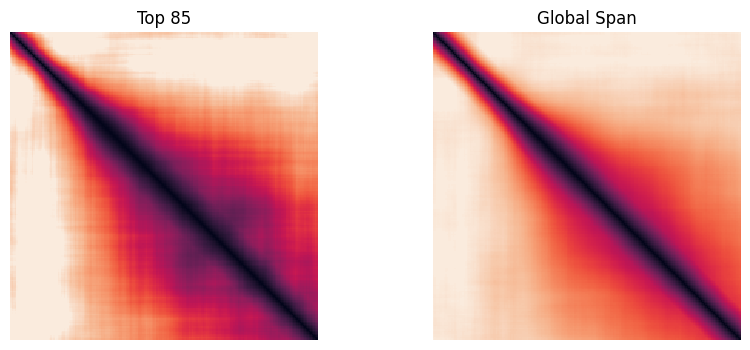

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

ax = axes[0]
sns.heatmap(Rt, vmax=1, 
            cbar=False, square=True, 
            ax=ax)
ax.set_axis_off()
ax.set_title(f'Top {scale}')

ax = axes[1]
sns.heatmap(Ra, vmax=1, 
            cbar=False, square=True, 
            ax=ax)
ax.set_axis_off()
ax.set_title('Global Span')

/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2241170937.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2241170937.py:22: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(


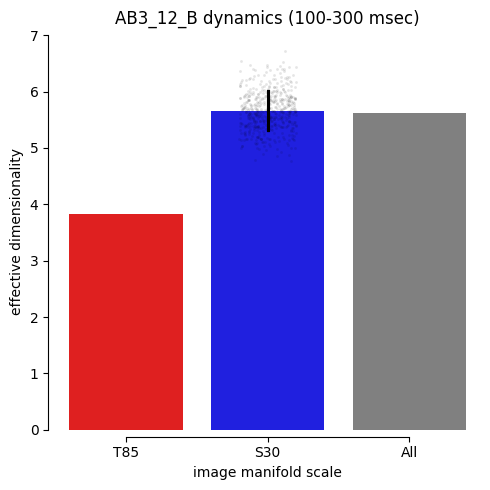

In [81]:
Vt = rdv(Rt)
Va = rdv(Ra)

# collect effective dimensionalities
Rs_EDs = np.array([ED2(Rs) for Rs in Rss])

conditions = [f'T{scale}', 'S30', 'All']

# build long-form dataframe so seaborn can handle stats + errorbars
rows = []

rows.append({'cond': conditions[0], 'ed': ED2(Rt), 'kind': 'test'})
for v in Rs_EDs:
    rows.append({'cond': conditions[1], 'ed': v, 'kind': 'shuffle'})
rows.append({'cond': conditions[2], 'ed': ED2(Ra), 'kind': 'all'})

df = pd.DataFrame(rows)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# bars (median + sd errorbars)
sns.barplot(
    data=df,
    x='cond',
    y='ed',
    order=conditions,
    estimator=np.median,
    errorbar='sd', errcolor='black',
    palette=['red', 'blue', 'gray'],
    ax=ax,
    zorder=1
)

# dots for the shuffle distribution (middle bar only)
sns.stripplot(
    data=df[df['cond'] == conditions[1]],
    x='cond',
    y='ed',
    order=conditions,
    color='black',
    size=2,
    jitter=0.2,
    alpha=0.1,
    ax=ax,
    zorder=2
)

ax.set_title(f'{ROI} dynamics ({t0}-{t0+window} msec)')
ax.set_xlabel('image manifold scale')
ax.set_ylabel('effective dimensionality')

sns.despine(fig, trim=True, offset=5)
plt.tight_layout()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:47<00:00,  2.99it/s]
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(


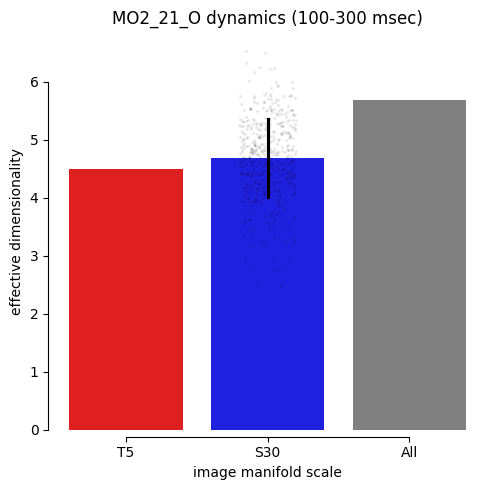

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:46<00:00, 10.81it/s]
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(


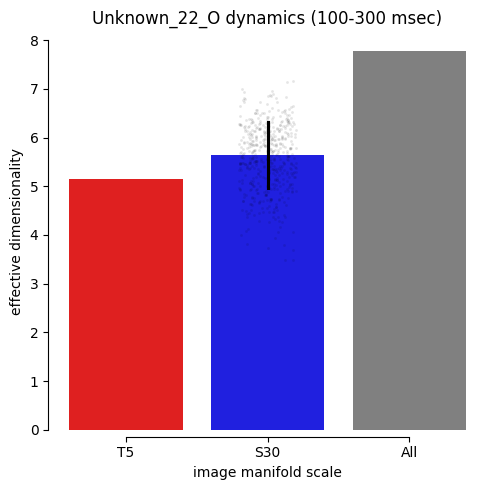

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:02<00:00,  2.74it/s]
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(


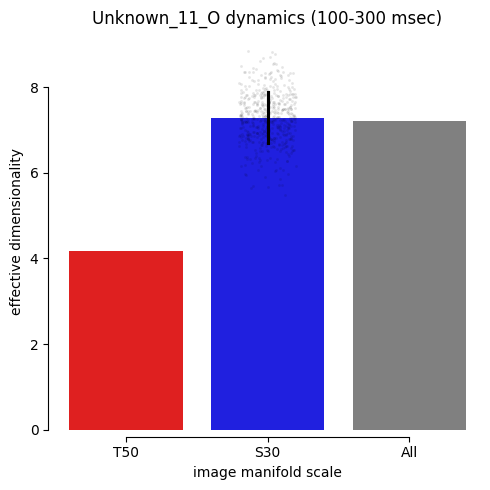

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:32<00:00, 15.54it/s]
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(


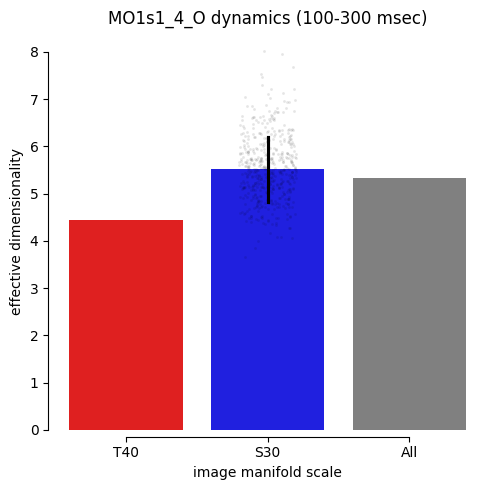

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:57<00:00,  4.24it/s]
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(


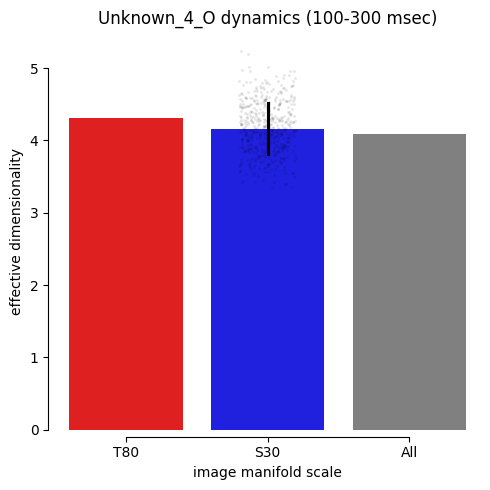

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:57<00:00,  4.27it/s]
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(


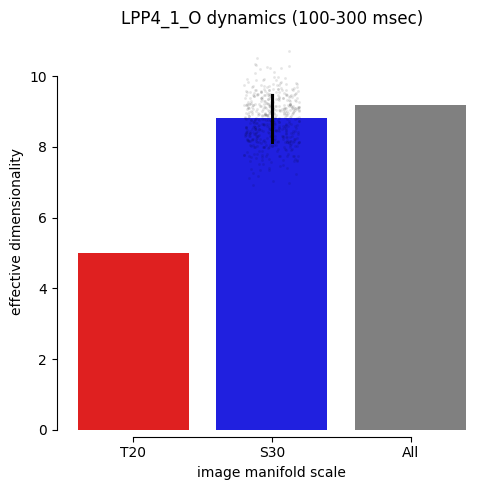

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:11<00:00,  1.60it/s]
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(


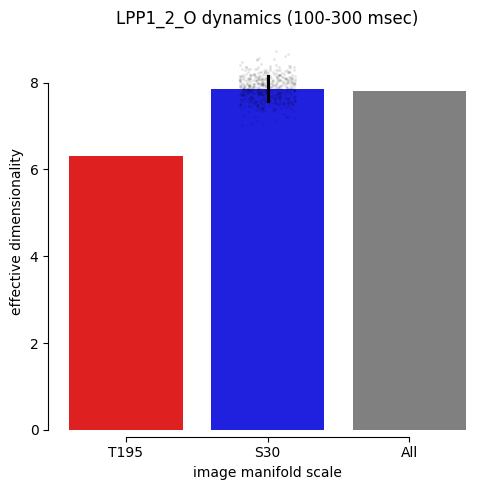

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:49<00:00,  4.55it/s]
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(


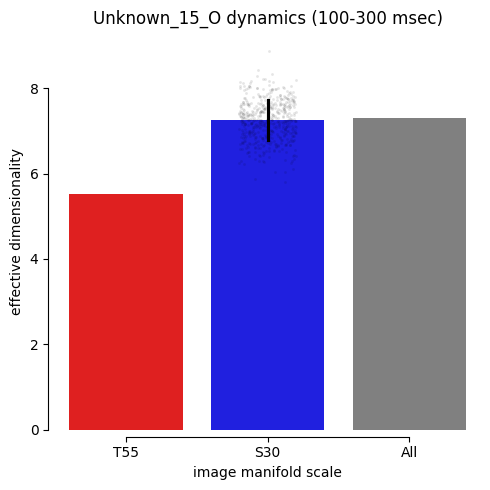

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:27<00:00,  3.40it/s]
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(


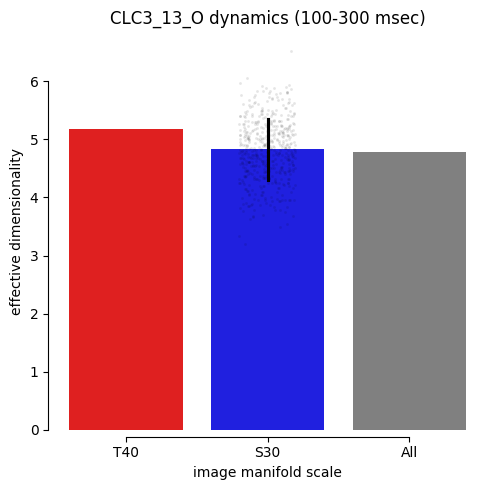

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:18<00:00,  2.52it/s]
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(


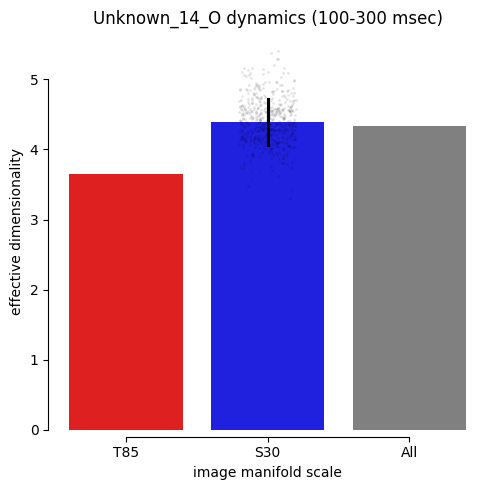

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 52.16it/s]
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(


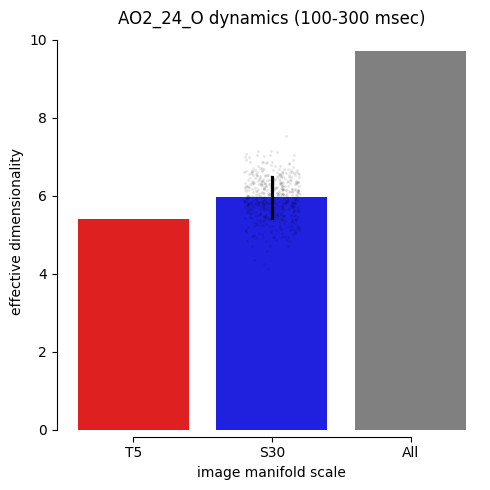

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:57<00:00,  2.82it/s]
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(


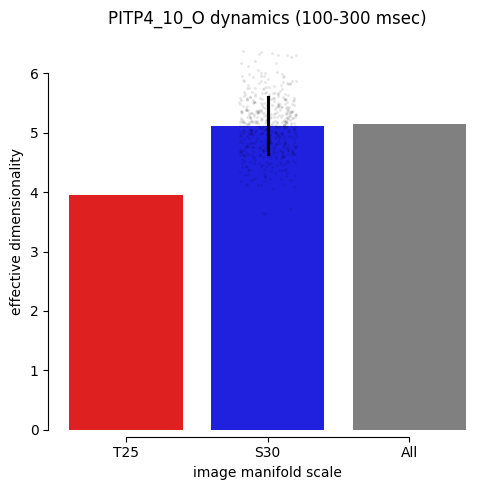

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:53<00:00,  9.28it/s]
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(


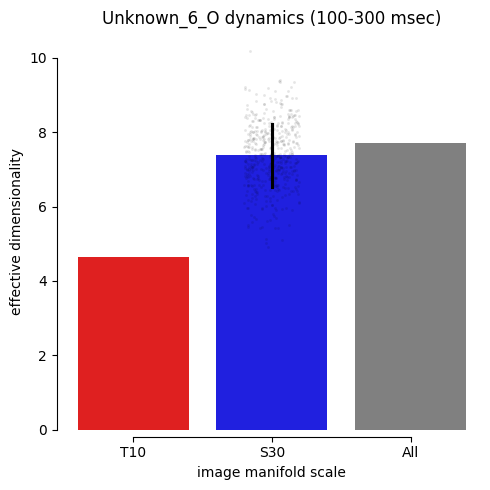

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:31<00:00,  5.48it/s]
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(


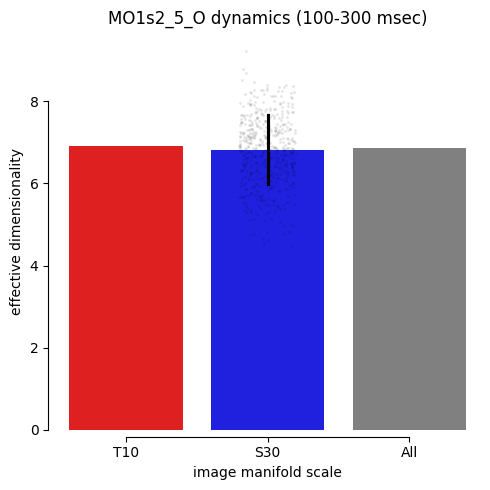

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:43<00:00,  1.45it/s]
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(


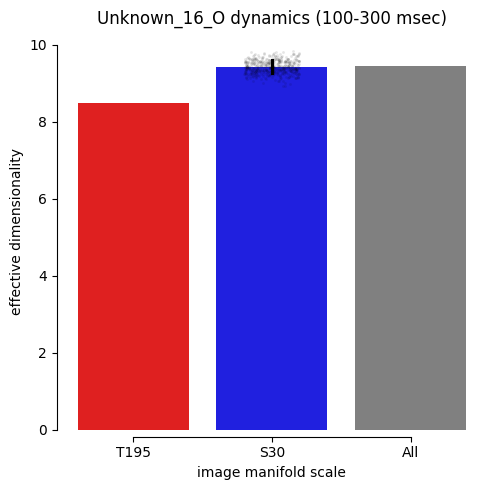

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.86it/s]
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(


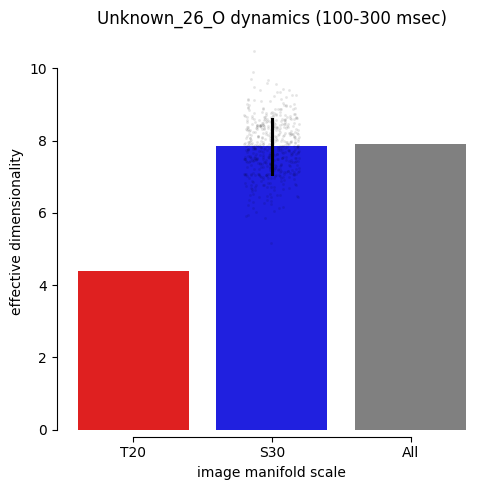

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.44it/s]
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_48931/2898974420.py:49: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  sns.barplot(


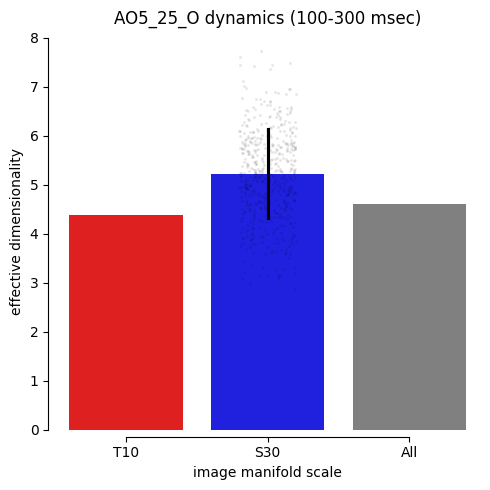

In [90]:
for ROI, SC in mins.items():
# for ROI in ['MB3_12_B', 'AB3_12_B', 'AB3_17_B', 'Unknown_27_B']: # not converging for: 'MB1_8_B', 'AB3_18_B',
    # SC = mins[ROI]
    scale = SC[0]
    
    MODE = 'top'
    # 100 t0, 200 window for medial
    # 150 to, 300 window for anterior
    t0 = 100 
    window = 200 #
    
    Rt, _ = static_rdm(dat, ROI, mode=MODE, scale=scale,
                      tstart=t0, tend=t0 + window)
    
    Ra, _ = static_rdm(dat, ROI, mode=MODE, scale=1072,
                      tstart=t0, tend=t0 + window)
    
    Rss = []
    for i in tqdm(range(500)):
        Rs, _ = static_rdm(dat, ROI, mode='shuff', scale=scale,
                          tstart=t0, tend=t0 + window, random_state=i)
        Rss.append(Rs)
    
    Vt = rdv(Rt)
    Va = rdv(Ra)

    try:
        # collect effective dimensionalities
        Rs_EDs = np.array([ED2(Rs) for Rs in Rss])
    except:
        Rs_EDs = [np.nan for _ in Rss]
        print(f'eigenvalues do not converge for ROI: {ROI}')
        
    conditions = [f'T{scale}', 'S30', 'All']
    
    # build long-form dataframe so seaborn can handle stats + errorbars
    rows = []
    
    rows.append({'cond': conditions[0], 'ed': ED2(Rt), 'kind': 'test'})
    for v in Rs_EDs:
        rows.append({'cond': conditions[1], 'ed': v, 'kind': 'shuffle'})
    rows.append({'cond': conditions[2], 'ed': ED2(Ra), 'kind': 'all'})
    
    df = pd.DataFrame(rows)
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    # bars (median + sd errorbars)
    sns.barplot(
        data=df,
        x='cond',
        y='ed',
        order=conditions,
        estimator=np.median,
        errorbar='sd', errcolor='black',
        palette=['red', 'blue', 'gray'],
        ax=ax,
        zorder=1
    )
    
    # dots for the shufsfle distribution (middle bar only)
    sns.stripplot(
        data=df[df['cond'] == conditions[1]],
        x='cond',
        y='ed',
        order=conditions,
        color='black',
        size=2,
        jitter=0.2,
        alpha=0.1,
        ax=ax,
        zorder=2
    )
    
    ax.set_title(f'{ROI} dynamics ({t0}-{t0+window} msec)')
    ax.set_xlabel('image manifold scale')
    ax.set_ylabel('effective dimensionality')
    
    sns.despine(fig, trim=True, offset=5)
    plt.tight_layout()
    plt.show()